In [1]:
import torch as tc
tc.set_default_tensor_type(tc.DoubleTensor)

In [2]:
from __future__ import division 
import sys, platform, os
sys.setrecursionlimit(4500) 

import numpy as np
import scipy as sp
from scipy.integrate import odeint, solve_bvp, solve_ivp

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [10]:
# K = -1

def TurningPoint(nu, l):
    return tc.arcsinh(tc.sqrt(l*(l+1) / nu**2))

# Definitions for sink and tank functions

def sink(x):
    return tc.sinh(x)

def tank(x):
    return tc.tanh(x)

def dsink(x):
    return tc.cosh(x)

def dtank(x):
    return 1 / tc.cosh(x)**2

# Definitions for l=0 and l=1 modes

def Phi0nu(nu, x):
    return tc.sin(nu * x)/ nu / sink(x)

def Phi1nu(nu, x):
    return Phi0nu(nu, x) * (1 / tank(x) - nu / tc.tan(nu * x)) / tc.sqrt(nu**2 + 1)

def dPhi0nu(nu, x):
    return (nu * tc.cos(nu * x) * sink(x) - tc.sin(nu * x) * dsink(x)) / nu / sink(x)**2

# def dPhiByPhi_recurrence(nu, l, ratio, x):
#     return l / tank(x) + tc.sqrt(nu**2 + (l+1)**2) * ratio

# Recurrence coefficients

def alphal(nu, l, x):
    return (2*l + 1) / tank(x) / tc.sqrt(nu**2 + (l+1)**2)

def betal(nu, l):
    return -tc.sqrt(nu**2 + l**2) / tc.sqrt(nu**2 + (l+1)**2)

def ratio_list_modified(nu_int, lmax, x):
    '''
        ratio_l := -y_{l+1} / y_l = beta_{l+1}/(alpha_{l+1} + ...)
                0<=l<=lmax-1
    '''
    res = tc.zeros([lmax, len(x)])
    nu = tc.tensor(nu_int, dtype=tc.float64)
    l_large = 2 * lmax
    
    temp = - tc.sqrt(nu**2 + (l_large + 1)**2) * tank(x) / (2 * l_large + 1)
    for ll in tc.arange(l_large - 1, lmax - 1, -1):
        temp = betal(nu, ll) / (alphal(nu, ll, x) + temp)
        
    res[-1] = temp # which corresponds to y_{lmax}/y_{lmax-1}
    llist = tc.arange(lmax - 2, 0, -1)
    for li in llist:
        res[li] = betal(nu, li + 1) / (alphal(nu, li + 1, x) + res[li+1])

    return res

# Computation

def Recurrence(nu_int, x, lmax = 2000):
    '''
        Input:  nu          int
                x           (N) torch tensor

        Output: Phi_l^nu    (lmax * N) torch tensor with 0<=l<=nu-1
    '''

    phi = tc.zeros([lmax, len(x)])
    # dphi = tc.zeros([lmax, len(x)])
    nu = tc.tensor(nu_int, dtype=tc.float64)

    phi[0] = Phi0nu(nu, x)
    phi[1] = Phi1nu(nu, x)

    llist = tc.arange(2, min(nu_int,lmax))
    rlist = ratio_list_modified(nu_int, lmax, x)


    # dphi[0] = dPhi0nu(nu, x)
    # dphi[1] = dPhiByPhi_recurrence(nu, 1, rlist[0], x) * phi[1]

    for li in llist:
        phi[li] = tc.where(x > TurningPoint(nu_int, li),  # turning point condition
                            alphal(nu, li-1, x) * phi[li-1] + betal(nu, li-1) * phi[li-2],  # forward recurrence
                            -rlist[li - 1] * phi[li - 1]) # backward recurrence
        
        # dphi[li] = dPhiByPhi_recurrence(nu, li, rlist[li], x) * phi[li]

    return phi#, dphi

def Recurrence_specified(nu_int, x, lmax = 2000):
    '''
        Input:  nu          int
                x           (N) torch tensor

        Output: Phi_l^nu    (lmax * N) torch tensor with 0<=l<=nu-1
    '''
    if lmax == False:
        lmax = nu_int

    phi = tc.zeros([lmax, len(x)])
    nu = tc.tensor(nu_int, dtype=tc.float64)

    phi[0] = Phi0nu(nu, x)
    phi[1] = Phi1nu(nu, x)

    llist = tc.arange(2, min(nu_int,lmax))
    rlist = ratio_list_modified(nu_int, lmax, x)

    for li in llist:
        phi[li] = tc.where(x > TurningPoint(nu_int, li),  # turning point condition
                            alphal(nu, li-1, x) * phi[li-1] + betal(nu, li-1) * phi[li-2],  # forward recurrence
                            -rlist[li - 1] * phi[li - 1]) # backward recurrence
    
    phi_at_0 = tc.zeros([lmax, 1])
    phi_at_0[0] = tc.tensor([1.])
    phi_tot = tc.hstack([phi, phi_at_0])

    return phi_tot #, dphi

In [19]:
xstart = 5e-8
xend = 7.5e-1

n1 = 100
n2 = 1000
n3 = 10000

testx1 = tc.linspace(xstart, xend, n1*2)
testx2 = tc.linspace(xstart, xend, n2*2)
testx3 = tc.linspace(xstart, xend, n3*2)


res1_Phi = Recurrence(n1, testx1, lmax = 2000)
res2_Phi = Recurrence(n2, testx2, lmax = 2000)
res3_Phi = Recurrence(n3, testx3, lmax = 2000)

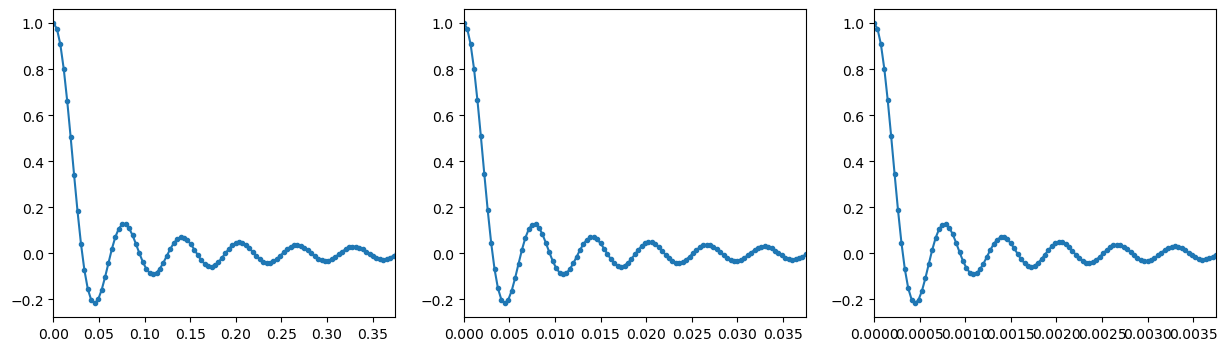

In [20]:
figs = plt.figure(figsize=(15,4))

plt.subplot(131)
plt.plot(testx1, res1_Phi[0], '.-')
plt.xlim([0, xend * 50 / n1])

plt.subplot(132)
plt.plot(testx2, res2_Phi[0], '.-')
plt.xlim([0, xend * 50 / n2])

plt.subplot(133)
plt.plot(testx3, res3_Phi[0], '.-')
plt.xlim([0, xend * 50 / n3])

plt.show()

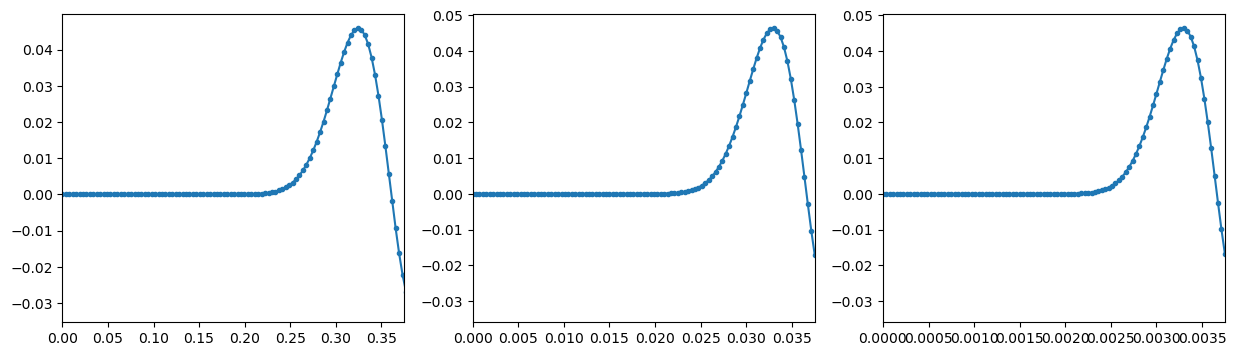

In [21]:
lindex = 30

figs = plt.figure(figsize=(15,4))

plt.subplot(131)
plt.plot(testx1, res1_Phi[lindex], '.-')
plt.xlim([0, xend * 50 / n1])

plt.subplot(132)
plt.plot(testx2, res2_Phi[lindex], '.-')
plt.xlim([0, xend * 50 / n2])

plt.subplot(133)
plt.plot(testx3, res3_Phi[lindex], '.-')
plt.xlim([0, xend * 50 / n3])

plt.show()

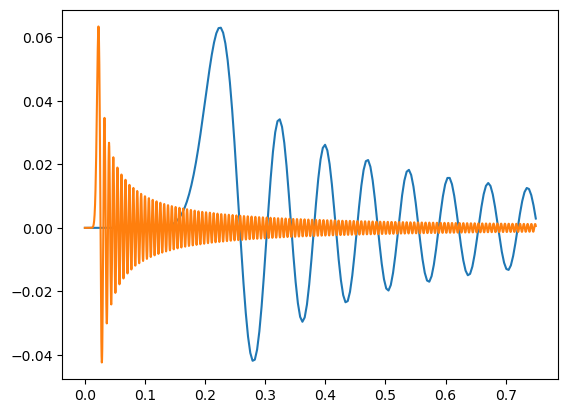

In [26]:
testli = 20
plt.plot(testx1, res1_Phi[testli]) 
plt.plot(testx2, res2_Phi[testli]) 

# plt.xlim([0.2, 0.4])
# plt.ylim([-0.3,1.1])

plt.show()

In [30]:
testx2.shape

torch.Size([2000])